In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import xgboost as xgb

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.metrics import log_loss
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv( "/content/drive/MyDrive/Orga Datos/TP2/Training.csv" )
test = pd.read_csv( "/content/drive/MyDrive/Orga Datos/TP2/Test.csv" )
test

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_171,Product_Name_332,EUR,0.325,USD,0.36761,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_140,Product_Name_241,EUR,0.275,USD,0.31105,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_171,Product_Name_328,EUR,0.325,USD,0.36761,6/1/2019,6/28/2019,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,6/1/2019,6/29/2019,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,16345,EMEA,KSA,1,1,0,0,0,Bureaucratic_Code_4,6/12/2017,Source_3,South Africa,Account_Name_1686,Opportunity_Name_11120,12364,6508,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_1,Non Binding,Delivery_Terms_7,4/26/2019,None,None,None,None,None,None,NaT,5/24/2019,4/26/2019,Person_Name_13,Product_Family_213,Product_Name_447,USD,0.300,USD,0.30000,5/1/2019,5/10/2019,2019 - 5,Q2,2019,NaT,0,USD,124740.0,USD,147750.0,Prod_Category_A_None
2547,15218,Americas,SE America,1,1,0,0,0,Bureaucratic_Code_4,6/8/2018,None,United States,Account_Name_768,Opportunity_Name_9694,12365,6510,Person_Name_38,Person_Name_38,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_4,4/26/2019,None,None,None,None,None,None,N

In [ ]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
df.drop('Total_Amount_Currency', axis = 1, inplace = True)

In [ ]:
test.loc[test['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = test['Total_Amount']*0.0096
test.loc[test['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

test.loc[test['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = test['Total_Amount']*1.17
test.loc[test['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

test.loc[test['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = test['Total_Amount']*0.70
test.loc[test['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

test.loc[test['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = test['Total_Amount']*1.29
test.loc[test['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
test.drop('Total_Amount_Currency', axis = 1, inplace = True)

In [ ]:
df = df[ df['Total_Amount'] > 0 ]
df['Total_Amount'] = np.log(df.Total_Amount)
df['TRF'] = np.log(df.TRF)

In [ ]:
test = test[ test['Total_Amount'] > 0 ]
test['Total_Amount'] = np.log(test.Total_Amount)
test['TRF'] = np.log(test.TRF)


In [ ]:
df = df.rename(columns={'Stage': 'Decision'})
df = df[ (df['Decision'] == 'Closed Won') | (df['Decision'] == 'Closed Lost') ]
df['Decision'] = np.where(df['Decision'] == 'Closed Won',1,0)
df.dropna(inplace=True)

In [ ]:

def dateToNum(x):
  return x.dt.day + x.dt.month*100 + x.dt.year*10000

In [ ]:
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'], errors='coerce')
df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'], errors='coerce')
df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'], errors='coerce')
df['Dates_diference'] = dateToNum(df['Planned_Delivery_End_Date']) - dateToNum(df['Planned_Delivery_Start_Date']) # Mejora la prediccion
df.loc[ df['Dates_diference'].isnull() ,('Dates_diference')] = 0


short_df = pd.DataFrame()
short_df['Decision'] = df['Decision']

short_df['Dates_diference'] = df['Dates_diference'] # Mejora la prediccion
#short_df['Month_created'] = pd.to_datetime(df['Account_Created_Date'], errors='coerce').dt.month


short_df['Bureaucratic_Code_0_Approval'] = df['Bureaucratic_Code_0_Approval'] # Mejora MUUY poco


#short_df['Quote_Type'] = np.where(df['Quote_Type'] == 'Non Binding',1,0) # Irrelevante


short_df['Pricing, Delivery_Terms_Quote_Appr'] = df['Pricing, Delivery_Terms_Quote_Appr'] # Mejora un poco el score


# Como de los otros codigos hay muy poca cantidad comparados con estos dos no nos importan
short_df['Bureaucratic_Code_4'] = np.where(df['Bureaucratic_Code'] == 'Bureaucratic_Code_4',1,0)
short_df['Bureaucratic_Code_5'] = np.where(df['Bureaucratic_Code'] == 'Bureaucratic_Code_5',1,0)


# Opportunity_Type

df["Opportunity_Type"] = np.where(df.groupby('Opportunity_Type')["Opportunity_Type"].transform(len) > 100, df["Opportunity_Type"], "Other")
mean_encoded_Opportunity_Type = df.groupby("Opportunity_Type")["Decision"].mean().to_dict()
short_df["Opportunity_Type"] = df["Opportunity_Type"].map(mean_encoded_Opportunity_Type)


# Account type

# OneHot encoding
# Como de los otros codigos hay muy poca cantidad comparados con estos tres no nos importan
#short_df['Account_Type_2'] = np.where(df['Account_Type'] == 'Account_Type_2',1,0)
#short_df['Account_Type_0'] = np.where(df['Account_Type'] == 'Account_Type_0',1,0)
#short_df['Account_Type_5'] = np.where(df['Account_Type'] == 'Account_Type_5',1,0)

# Mean encoding
df["Account_Type"] = np.where(df.groupby('Account_Type')["Account_Type"].transform(len) > 5, df["Account_Type"], "Other")
mean_encoded_account = df.groupby("Account_Type")["Decision"].mean().to_dict()
short_df["Account_Type"] = df["Account_Type"].map(mean_encoded_account)


# Region

# mean encoding
df["Region"] = np.where(df.groupby('Region')["Region"].transform(len) > 5, df["Region"], "Other")
mean_encoded_region = df.groupby("Region")["Decision"].mean().to_dict()
short_df["Region"] = df["Region"].map(mean_encoded_region)

# OneHot encoding
#short_df['Region_Japon'] = np.where(df['Region'] == 'Japan',1,0)
#short_df['Region_EMEA '] = np.where(df['Region'] == 'EMEA',1,0)
#short_df['Region_Americas'] = np.where(df['Region'] == 'Americas',1,0)
#short_df['Region_Apac'] = np.where(df['Region'] == 'APAC',1,0)
#short_df['Region_Middle_East'] = np.where(df['Region'] == 'Middle East',1,0)


# Opportunity Owner
df["Opportunity_Owner"] = np.where(df.groupby('Opportunity_Owner')["Opportunity_Owner"].transform(len) > 5, df["Opportunity_Owner"], "Other")
mean_encoded_owner = df.groupby("Opportunity_Owner")["Decision"].mean().to_dict()
short_df["Opportunity_Owner"] = df["Opportunity_Owner"].map(mean_encoded_owner)

# Prodcut name
df["Product_Name"] = np.where(df.groupby('Product_Name')["Product_Name"].transform(len) > 5, df["Product_Name"], "Other")
mean_encoded_product = df.groupby("Product_Name")["Decision"].mean().to_dict() # Mean Encoding
dict_product_name = {k: i for i, k in enumerate(df['Product_Name'].unique())} # Label Encoding
short_df["Product_Name"] = df["Product_Name"].map(dict_product_name)


# Entorpece el aprendizaje
#short_df['TRF'] = df['TRF'] # Entorpece el aprendizaje
#short_df['TRF_Above_average'] =  df['TRF'] > df['TRF'].mean()
#short_df['TRF_Above_average'] = np.where(short_df['TRF_Above_average'] == True,1,0)

short_df['Total_Amount'] = df['Total_Amount'] # Es la mejor
#short_df['Total_Amount_Above_average'] =  df['Total_Amount'] > df['Total_Amount'].mean()
#short_df['Total_Amount_Above_average'] = np.where(short_df['Total_Amount_Above_average'] == True,1,0)
#short_df["Expensive"] = np.where(df["Total_Taxable_Amount"] >= 80000, 1, 0)

short_df.dropna(inplace=True)
short_df

,Decision,Dates_diference,Bureaucratic_Code_0_Approval,"Pricing, Delivery_Terms_Quote_Appr",Bureaucratic_Code_4,Bureaucratic_Code_5,Opportunity_Type,Account_Type,Region,Opportunity_Owner,Product_Name,Total_Amount
0,0,129.0,1,1,1,0,0.538700,0.504613,0.532255,0.560776,0.0,15.635076
1,1,2.0,0,0,1,0,0.538700,0.504613,0.532255,0.750000,1.0,10.940740
2,1,0.0,0,0,1,0,0.538700,0.307692,0.466840,0.599112,2.0,11.336971
3,0,130.0,1,1,0,1,0.217002,0.307692,0.466840,0.599112,3.0,15.819943
4,0,27.0,1,1,0,1,0.217002,0.307692,0.466840,0.599112,3.0,16.407566
...,...,...,...,...,...,...,...,...,...,...,...,...
16942,1,4.0,1,1,1,0,0.538700,0.307692,0.532255,0.664537,24.0,11.702880
16943,1,4.0,1,1,1,0,0.538700,0.307692,0.532255,0.664537,24.0,11.597520
16944,1,3.0,1,1,1,0,0.538700,0.307692,0.532255,0.664537,24.0,11.702880
16945,0,4.0,1,1,1,0,0.538700,0.307692,0.466840,0.276316,25.0,14.668562


In [ ]:
short_df.isnull().sum()

Decision                              0
Dates_diference                       0
Bureaucratic_Code_0_Approval          0
Pricing, Delivery_Terms_Quote_Appr    0
Bureaucratic_Code_4                   0
Bureaucratic_Code_5                   0
Opportunity_Type                      0
Account_Type                          0
Region                                0
Opportunity_Owner                     0
Product_Name                          0
Total_Amount                          0
dtype: int64

In [ ]:
test['Planned_Delivery_Start_Date'] = pd.to_datetime(test['Planned_Delivery_Start_Date'], errors='coerce')
test['Planned_Delivery_End_Date'] = pd.to_datetime(test['Planned_Delivery_End_Date'], errors='coerce')
test['Account_Created_Date'] = pd.to_datetime(test['Account_Created_Date'], errors='coerce')
test['Dates_diference'] = dateToNum(test['Planned_Delivery_End_Date']) - dateToNum(test['Planned_Delivery_Start_Date']) # Mejora la prediccion
test.loc[ test['Dates_diference'].isnull() , ('Dates_diference')] = 0

short_test = pd.DataFrame()
short_test['Dates_diference'] = test['Dates_diference'] # Mejora la prediccion

#short_test['Month_created'] = pd.to_datetime(test['Account_Created_Date'], errors='coerce').dt.month
#short_test['Month_created'] = test['Account_Created_Date'].dt.month


short_test['Bureaucratic_Code_0_Approval'] = test['Bureaucratic_Code_0_Approval'] # Mejora MUUY poco

short_test['Pricing, Delivery_Terms_Quote_Appr'] = test['Pricing, Delivery_Terms_Quote_Appr'] # Mejora un poco el score

# Bureaucratic_Code
short_test['Bureaucratic_Code_4'] = np.where(test['Bureaucratic_Code'] == 'Bureaucratic_Code_4',1,0)
short_test['Bureaucratic_Code_5'] = np.where(test['Bureaucratic_Code'] == 'Bureaucratic_Code_5',1,0)


# Opportunity_Type

short_test["Opportunity_Type"] = test["Opportunity_Type"].map(mean_encoded_Opportunity_Type)
short_test.loc[ short_test['Opportunity_Type'].isnull() ,('Opportunity_Type')] = mean_encoded_Opportunity_Type.get('Other')

# Account_Type
short_test["Account_Type"] = test["Account_Type"].map(mean_encoded_account)

# Region 
short_test["Region"] = test["Region"].map(mean_encoded_region)

# Opportunity_Owner
short_test["Opportunity_Owner"] = test["Opportunity_Owner"].map(mean_encoded_owner)
short_test.loc[ short_test['Opportunity_Owner'].isnull() ,('Opportunity_Owner')] = mean_encoded_owner.get('Other')

# Product_Name
short_test["Product_Name"] = test["Product_Name"].map(dict_product_name)
short_test.loc[ short_test['Product_Name'].isnull() ,('Product_Name')] = 0

#short_test['TRF'] = test['TRF'] #Muy probable que sea una caca

# Total_Amount
short_test['Total_Amount'] = test['Total_Amount'] # Es la mejor



In [ ]:
short_test.isnull().sum()


Dates_diference                       0
Bureaucratic_Code_0_Approval          0
Pricing, Delivery_Terms_Quote_Appr    0
Bureaucratic_Code_4                   0
Bureaucratic_Code_5                   0
Opportunity_Type                      0
Account_Type                          0
Region                                0
Opportunity_Owner                     0
Product_Name                          0
Total_Amount                          0
dtype: int64

# XGBoost

In [ ]:
X = short_df.drop( 'Decision', axis=1 )
y = short_df['Decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
#xg_Regressor1 = xgb.XGBRegressor(colsample_bytree= 0.8, gamma= 1.5, learning_rate= 0.01, max_depth= 20, min_child_weight= 1, n_estimators= 200, subsample= 0.8)
xg_Regressor1 = xgb.XGBRegressor(colsample_bytree= 0.8, gamma= 1.5, learning_rate= 0.01, max_depth= 20, min_child_weight= 1, n_estimators= 250, subsample= 0.8)

xg_Regressor1.fit(X_train,y_train)
xgbr = xg_Regressor1.predict(X_test)

[15:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
loss = log_loss(y_test, xgbr)
print(f"Log loss is {loss}")

Log loss is 0.4054568658551791


In [ ]:
xg_Regressor1.score(X_test, y_test)


0.4862298151447473

Text(0.5, 1.0, 'XGBoost Regressor')

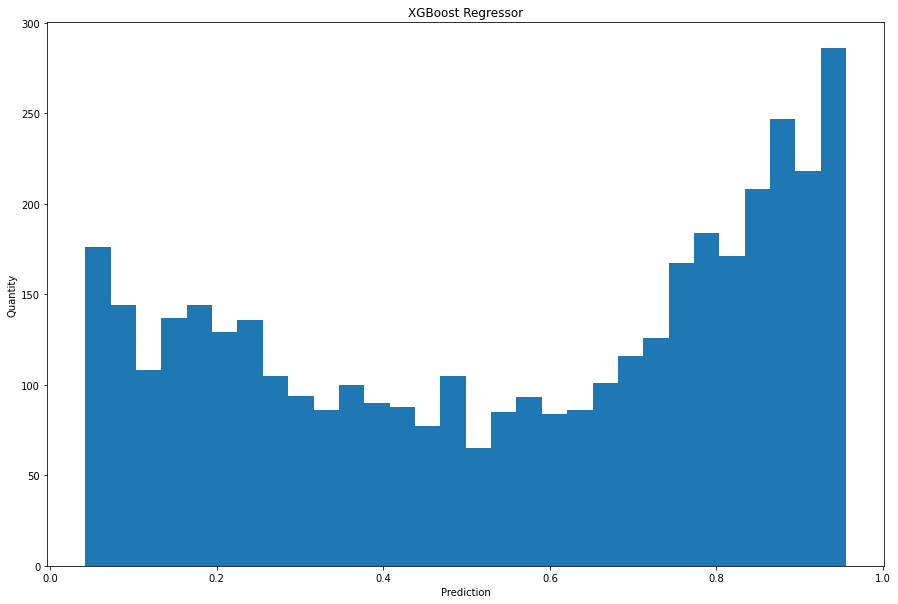

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(xgbr, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('XGBoost Regressor')

['Dates_diference', 'Bureaucratic_Code_0_Approval', 'Pricing, Delivery_Terms_Quote_Appr', 'Bureaucratic_Code_4', 'Bureaucratic_Code_5', 'Opportunity_Type', 'Account_Type', 'Region', 'Opportunity_Owner', 'Product_Name', 'Total_Amount']


Text(0.5, 0, 'Relative Importance')

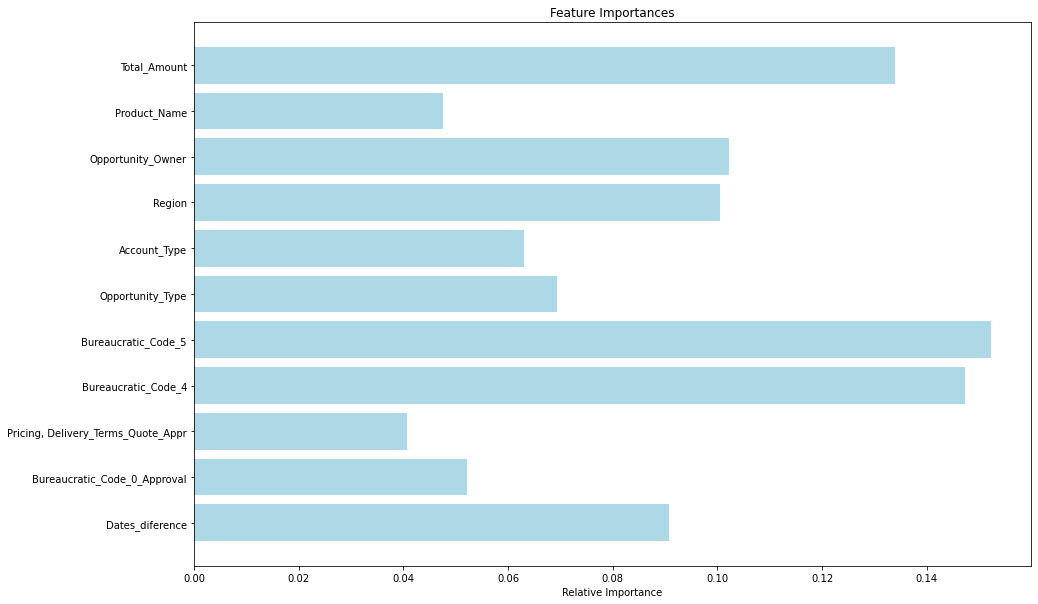

In [ ]:
features = X_test.columns.to_list()
importances = xg_Regressor1.feature_importances_
indices = np.argsort(importances)

print(features)


plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(features, importances, color='lightblue', align='center' )
plt.xlabel('Relative Importance')

# CatBoost

In [ ]:
#cbr = CatBoostRegressor(learning_rate = 0.0075, verbose = True, random_seed = 123,  num_boost_round = 1500, max_depth = 14)
#cbr = CatBoostRegressor(num_boost_round = 1500, depth= 10, l2_leaf_reg= 20, learning_rate= 0.008)
cbr = CatBoostRegressor(num_boost_round = 1500, learning_rate = 0.008)
cbr.fit(X_train, y_train)
cbr_pred = cbr.predict(X_test)

In [ ]:
loss = log_loss(y_test, cbr_pred)
print(f"Log loss is {loss}")

Log loss is 0.4238344688021329


In [ ]:
cbr.score(X_test, y_test)

0.46568382196541525

Text(0.5, 1.0, 'CatBoost Regressor')

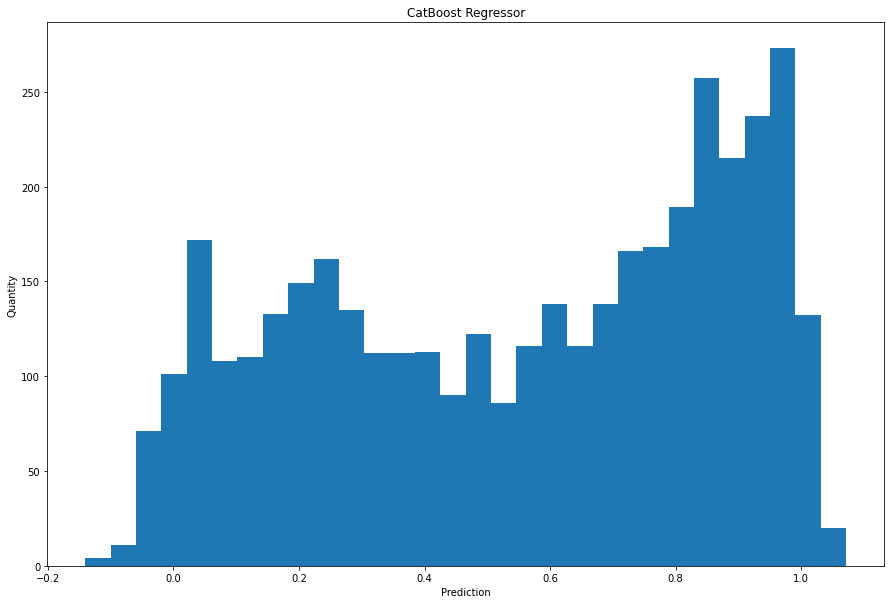

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(cbr_pred, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('CatBoost Regressor')

['Dates_diference', 'Bureaucratic_Code_0_Approval', 'Pricing, Delivery_Terms_Quote_Appr', 'Bureaucratic_Code_4', 'Bureaucratic_Code_5', 'Opportunity_Type', 'Account_Type', 'Region', 'Opportunity_Owner', 'Product_Name', 'Total_Amount']


Text(0.5, 0, 'Relative Importance')

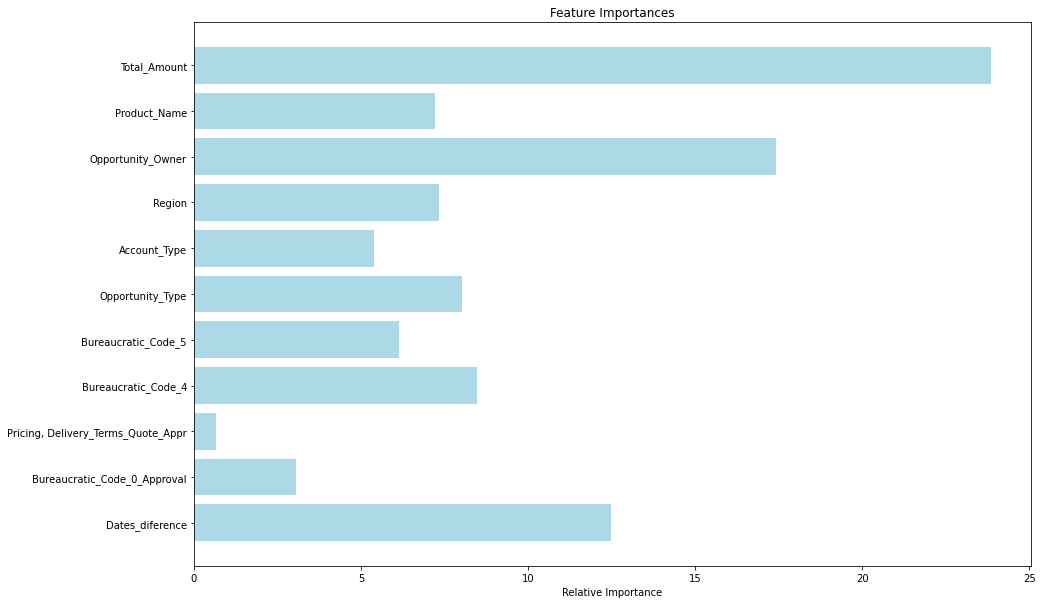

In [ ]:
features = X_test.columns.to_list()
importances = cbr.feature_importances_
indices = np.argsort(importances)

print(features)


plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(features, importances, color='lightblue', align='center')
plt.xlabel('Relative Importance')

# LightBM

In [ ]:
lbm = LGBMRegressor(boosting_type = "goss", n_estimators = 1500, learning_rate = 0.008, random_state=100)
lbm.fit(X_train, y_train)
lbm_pred = lbm.predict(X_test)


In [ ]:
loss = log_loss(y_test, lbm_pred)
print(f"Log loss is {loss}")

In [ ]:
lbm.score(X_test, y_test)


In [ ]:
plt.figure(figsize=(15,10))
plt.hist(lbm_pred, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('LightGBM Regressor')

In [ ]:
features = X_test.columns.to_list()
importances = lbm.feature_importances_
indices = np.argsort(importances)

print(features)


plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.bar(features, importances, color='b', align='center')
plt.xlabel('Relative Importance')

# Voting Regressor

In [ ]:
# , ('lbm', lbm)
ereg = VotingRegressor([ ('xgbr', xg_Regressor1), ('cbr', cbr) ])
ereg.fit(X_train, y_train)
ereg_pred = ereg.predict(X_test)


In [ ]:
loss = log_loss(y_test, ereg_pred)
print(f"Log loss is {loss}")

Log loss is 0.4039791734319871


In [ ]:
ereg.score(X_test, y_test)


0.48052191186436777

Text(0.5, 1.0, 'Regressor predictions and their average')

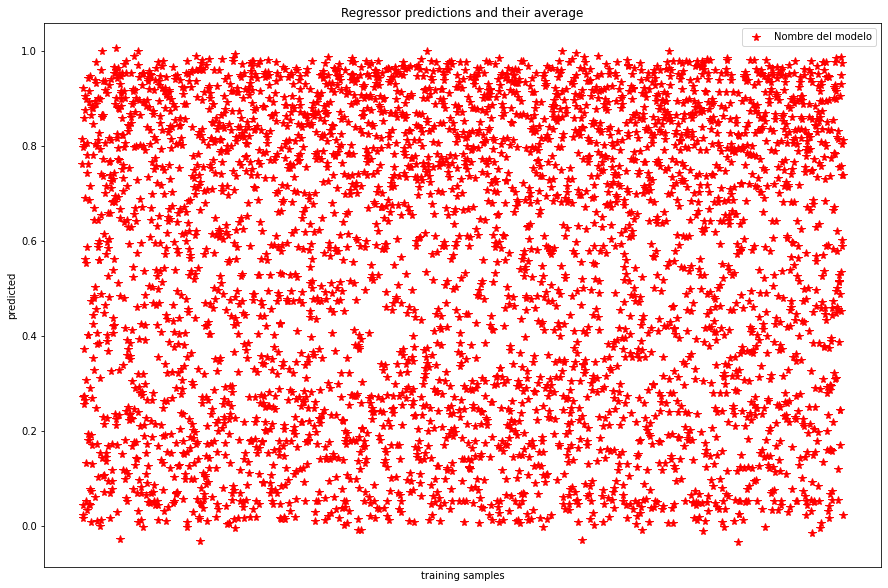

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(ereg_pred, 'r*', ms=8,label='Nombre del modelo')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')


Text(0.5, 1.0, 'Voting Regressor')

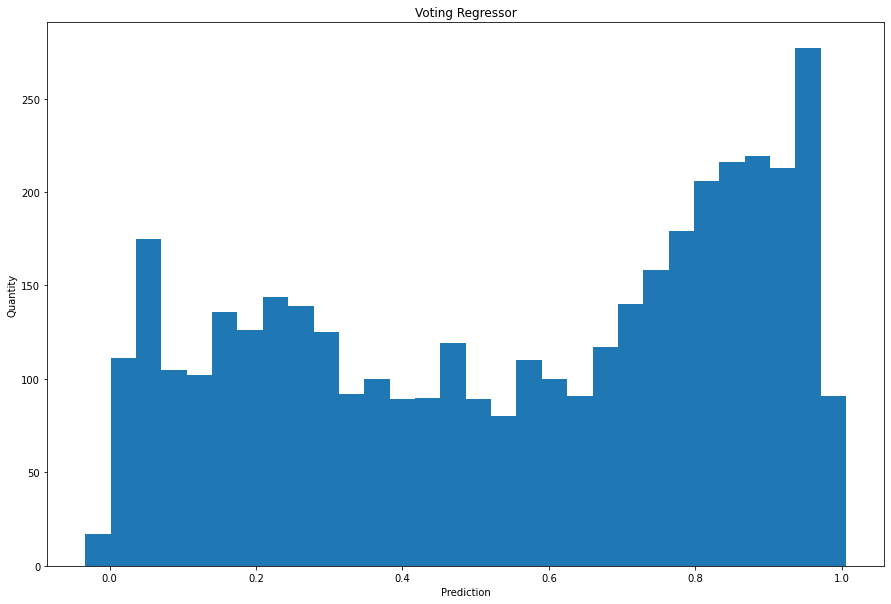

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(ereg_pred, bins=30)
plt.ylabel('Quantity')
plt.xlabel('Prediction')
plt.title('Voting Regressor')

In [ ]:
ereg_test = ereg.predict(short_test)

In [ ]:
resultado_voting = pd.DataFrame()
resultado_voting['Opportunity_ID'] = test['Opportunity_ID']
resultado_voting['target'] = ereg_test
resultado_voting.sort_values('Opportunity_ID',inplace = True)
resultado_voting = resultado_voting.drop_duplicates('Opportunity_ID',keep = 'last')
resultado_voting.set_index('Opportunity_ID', inplace = True)
resultado_voting.describe()


,target
count,1567.000000
mean,0.543578
std,0.255054
min,0.004768
25%,0.330445
50%,0.558923
75%,0.776948
max,0.993429


In [ ]:
csv3 = resultado_voting.to_csv('Ensamble_CB_XG_VR.csv')
#files.download('Ensamble_CB_XG_VR.csv')

# AdaBoost

In [ ]:
rng = np.random.RandomState(1)
ada = AdaBoostRegressor(ereg, n_estimators=300, random_state=rng)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [ ]:
loss = log_loss(y_test, ada_pred)
print(f"Log loss is {loss}")

Log loss is 0.4238977620964075


In [ ]:
ada.score(X_test, y_test)


0.46189632733441166

# Distribución de predicciones

Text(0.5, 1.0, 'Regressor predictions and their average')

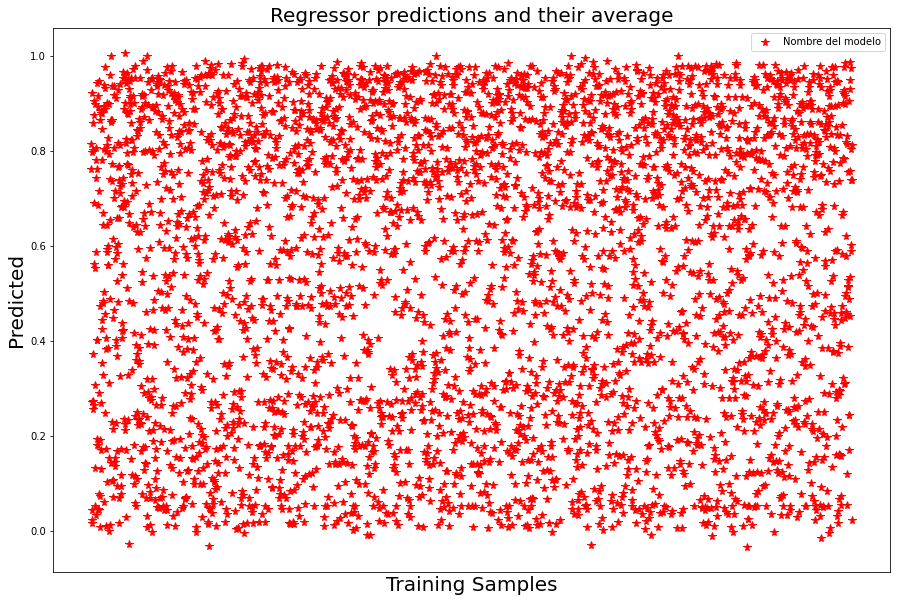

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(ereg_pred, 'r*', ms=8, label='Nombre del modelo')

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Predicted', fontsize = 20)
plt.xlabel('Training Samples', fontsize = 20)
plt.legend(loc="best")
plt.title('Regressor predictions and their average', fontsize = 20)

Text(0.5, 1.0, 'AdaBoost Regressor')

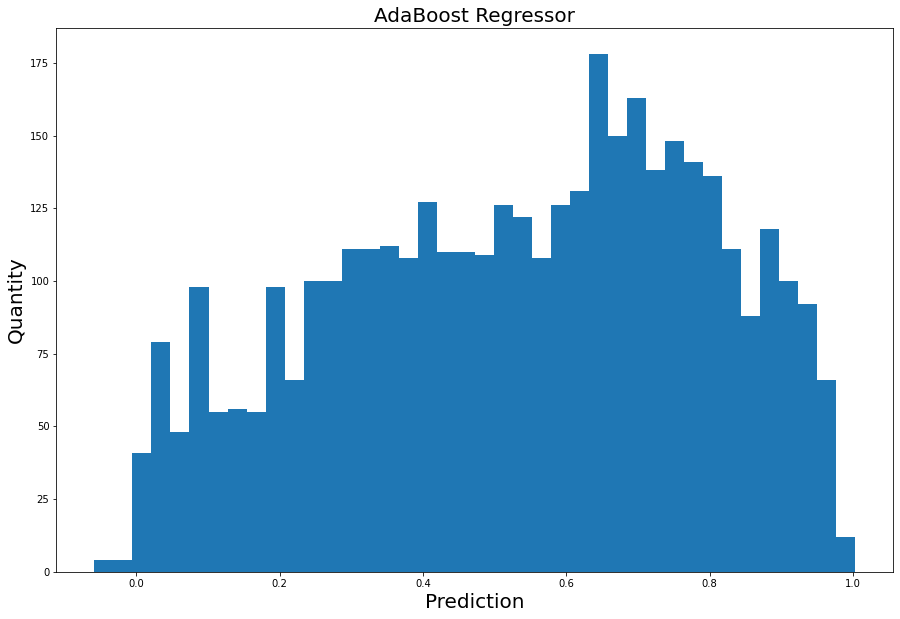

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(ada_pred, bins=40)
plt.ylabel('Quantity', fontsize = 20)
plt.xlabel('Prediction', fontsize = 20)
plt.title('AdaBoost Regressor', fontsize = 20)

In [ ]:
resultado = pd.DataFrame()
resultado['Opportunity_ID'] = test['Opportunity_ID']
resultado['target'] = ada_test
resultado.sort_values('Opportunity_ID',inplace = True)
resultado = resultado.drop_duplicates('Opportunity_ID',keep = 'last')
resultado.set_index('Opportunity_ID', inplace = True)
resultado.describe()

,target
count,1567.000000
mean,0.522771
std,0.196581
min,-0.006538
25%,0.392410
50%,0.540745
75%,0.673328
max,0.959335


# Arma csv de entrega

In [ ]:
csv3 = resultado.to_csv('Ensamble_CB_XG.csv')
#files.download('Ensamble_CB_XG.csv')

In [ ]:
ada_test = ada.predict(short_test)